In [1]:
# Leitor de dados da plataforma MT5
# Le os dados e salva em arquivos csv para nao ter que ficar buscando os dados
# e dependendo sempre da plataforma
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import MetaTrader5 as mt5
import pandas_ta as ta
import os as os
import plotly.graph_objects as go
import datetime  # For datetime objects
import backtrader as bt
import backtrader.indicators as btind
import ipympl
import math

%matplotlib widget

def get_mt5_time_frame(tf):
    if tf == 2:
        return mt5.TIMEFRAME_M2
    elif tf == 5:
        return mt5.TIMEFRAME_M5
    elif tf == 10:
        return mt5.TIMEFRAME_M10
    elif tf == 15:
        return mt5.TIMEFRAME_M15
    elif tf == 60:
        return mt5.TIMEFRAME_H1
    elif tf == 120:
        return mt5.TIMEFRAME_H2
    elif tf == "D":
        return mt5.TIMEFRAME_D1

def get_tf_name_alias(tf):
    if tf == 2:
        return "2M"
    elif tf == 5:
        return "5M"
    elif tf == 10:
        return "10M"
    elif tf == 15:
        return "15M"
    elif tf == 60:
        return "1H"
    elif tf == 120:
        return "2H"
    elif tf == "D":
        return "D"

# Baixa os dados dos ativos da bolsa e salva em CSV
def generate_database(tf,quantity_of_candles):
    mt5.initialize();
    with open('./bolsa.csv') as reader:
    
        lines = reader.readlines();
        # trocar qtde de intervalos que quiser
        
        # configurar timeframe desejado 
        mt5_tf = get_mt5_time_frame(tf)
        tf_alias = get_tf_name_alias(tf)
        for l in lines:
            ticker = l.translate({ord('\n'): None})
            # print(f"Importando {ticker}")
            try:
                importedData =  pd.DataFrame(mt5.copy_rates_from_pos(ticker, mt5_tf, 0, quantity_of_candles))
                if(not importedData.empty):
                    # Marca a coluna 'time' como indexador do DataFrame
                    importedData.set_index(pd.to_datetime(importedData['time'], unit='s'), inplace=True)
                    
                    # Ajusta o volume e calcula media + bb upper
                    importedData['volume'] = importedData['real_volume'].values / 1000
                    
                    # Limpa colunas nao utilizadas
                    importedData = importedData.drop(columns=['spread', 'real_volume'])
                    # print(f"saveToFile step=start file=./data/{ticker}-{tf_alias}.db.csv") 
                    importedData.to_csv(f"./data/{ticker}-{tf_alias}.db.csv")
                    # print(f"saveToFile step=success file=./data/{ticker}-{tf_alias}.db.csv")
                else:
                    print(f"saveToFile step=empty file=./data/{ticker}-{tf_alias}.db.csv")
            except Exception as ex:
                print(ex)
                print(f"saveToFile step=error ticker={ticker}")
    print(f"saveToFile step=end")
    mt5.shutdown()


def calc_zscores(mean_size):
    with open('./bolsa.csv') as reader:
        # Params
        lines = reader.readlines();
        zscores = pd.DataFrame()
        # configurar timeframe desejado 
        tf = "D"
        mt5_tf = get_mt5_time_frame(tf)
        tf_alias = get_tf_name_alias(tf)
        
        for l in lines:
            try:
                ticker = l.translate({ord('\n'): None})
                pathToFile = f"./data/{ticker}-{tf_alias}.db.csv"
                #print(f"openFile step=start file={pathToFile}")
                # Nem todos os arquivos da lista tem dados (exemplo papeis de-listados que ainda estao no sistema ex:VVIT4)
                
                if(os.path.exists(pathToFile)):
                    fromCSV = pd.read_csv(pathToFile)
                    closePrice = pd.DataFrame();
                    if(not fromCSV.empty):
                        # Apenas a coluna de preco de fechamento
                        closePrice[ticker] = fromCSV['close']
                        calcs = pd.DataFrame();
                        calcs[f"{ticker}close"] = closePrice[ticker]
                        calcs[f"{ticker}mean"] = closePrice.loc[:, ticker].rolling(window=mean_size).mean()
                        calcs[f"{ticker}stddev"] = closePrice.loc[:, ticker].rolling(window=mean_size).std(ddof=0)
                        # ZScore = (Fechamento - media)/desvio
                        zscores[ticker] = (calcs[f"{ticker}close"] - calcs[f"{ticker}mean"]) / calcs[f"{ticker}stddev"] 
                        last = len(zscores[ticker]) -1
                        # Acima de dois desvios da media 
                        if(zscores[ticker][last] >= 2.0 or zscores[ticker][last] <= -2.0):
                            print(f"{ticker}\tmean={mean_size}\tz-score={zscores[ticker][last]}")
               
            except Exception as ex:
                print(ex) # Do nothing
                #print(f"openFile step=error file={pathToFile}")
                
def load_from_db(ticker, tf):
    print(f"m=load_from_db step=start {ticker}")
    tf_alias = get_tf_name_alias(tf)
    pathToFile = f"./data/{ticker}-{tf_alias}.db.csv"
    if(os.path.exists(pathToFile)):
        fromCSV = pd.read_csv(pathToFile)
        if(not fromCSV.empty):
            print(f"m=load_from_db step=success {pathToFile}")
            return fromCSV
        else:
            print(f"m=load_from_db step=empty {pathToFile}")
            return None;
        

def build_fig(someDf):
    fig = go.Figure(data=[go.Candlestick(x=someDf['time'],
                open=someDf['open'],
                high=someDf['high'],
                low=someDf['low'],
                close=someDf['close'])])
    fig.update_layout(height=1000)
    return fig;


In [7]:
pip install ipympl 

Note: you may need to restart the kernel to use updated packages.


In [10]:
generate_database("D", 200)

saveToFile step=empty file=./data/BEEF11-D.db.csv
saveToFile step=empty file=./data/BRDT3-D.db.csv
saveToFile step=empty file=./data/BTOW3-D.db.csv
saveToFile step=empty file=./data/CCPR3-D.db.csv
saveToFile step=empty file=./data/CCXC3-D.db.csv
saveToFile step=empty file=./data/CEEB6-D.db.csv
saveToFile step=empty file=./data/CMSA3-D.db.csv
saveToFile step=empty file=./data/CMSA4-D.db.csv
saveToFile step=empty file=./data/CNSY3-D.db.csv
saveToFile step=empty file=./data/COCE6-D.db.csv
saveToFile step=empty file=./data/CORR3-D.db.csv
saveToFile step=empty file=./data/CPRE3-D.db.csv
saveToFile step=empty file=./data/CREM3-D.db.csv
saveToFile step=empty file=./data/CTCA3-D.db.csv
saveToFile step=empty file=./data/CTSA8-D.db.csv
saveToFile step=empty file=./data/DTCY4-D.db.csv
saveToFile step=empty file=./data/DTEX3-D.db.csv
saveToFile step=empty file=./data/ELEK3-D.db.csv
saveToFile step=empty file=./data/ELEK4-D.db.csv
saveToFile step=empty file=./data/ELPL3-D.db.csv
saveToFile step=emp

""


m=load_from_db step=start VALE3
m=load_from_db step=success ./data/VALE3-D.db.csv


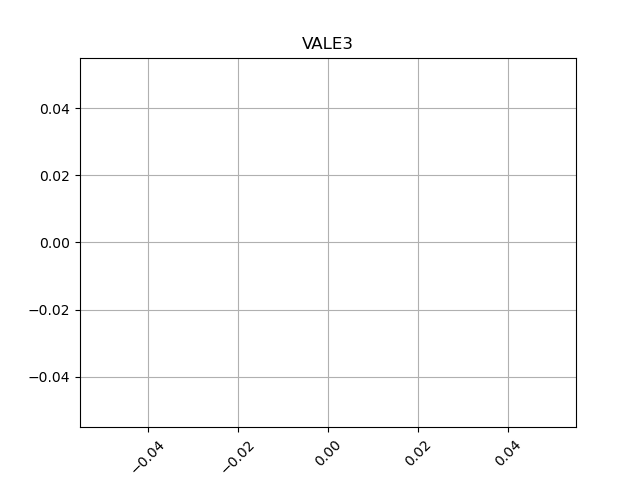

In [3]:
# Transforma para o modelo de dados que o Cerebro consome
ticker = "VALE3"
df = load_from_db(f"{ticker}", "D")
df = df.drop(columns = ['time.1','tick_volume'])
df.to_csv(f"{ticker}.csv", index = False)

bbands = btind.BBands(df['close'], period=20, devfactor=2)

df_to_plot = df[['time','close']]
df_to_plot.set_index('time', inplace=True)

%matplotlib widget
plt.grid(True)
plt.title(f"{ticker}")
plt.xticks(rotation=45)

# Plotando um periodo menor pq ficou pesado
plt.plot(df_to_plot.iloc[480:500], label="Preço")
plt.plot(df_to_plot.iloc[480:500], "ro")
plt.show()

In [22]:
len(df)

500

In [4]:
# Create a Stratey
class TestStrategy(bt.Strategy):

    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close

        # To keep track of pending orders and buy price/commission
        self.order = None
        self.buyprice = None
        self.buycomm = None

    def notify_order(self, order):
        #self.log("m=notify_order")
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        self.order = None
        
    def notify_trade(self, trade):
        self.log(f"m=notify_trade")
        help(trade)

    def next(self):
        # Simply log the closing price of the series from the reference
        # self.log('Close, %.2f' % self.dataclose[0])

        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return

        # Check if we are in the market
        if not self.position:

            # Not yet ... we MIGHT BUY if ...
            if self.dataclose[0] < self.dataclose[-1]:
                    # current close less than previous close

                    if self.dataclose[-1] < self.dataclose[-2]:
                        # previous close less than the previous close

                        # BUY, BUY, BUY!!! (with default parameters)
                        #self.log('BUY CREATE, %.2f' % self.dataclose[0])

                        # Keep track of the created order to avoid a 2nd order
                        self.order = self.buy()

        else:

            # Already in the market ... we might sell
            if len(self) >= (self.bar_executed + 5):
                # SELL, SELL, SELL!!! (with all possible default parameters)
                #self.log('SELL CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.sell()


In [15]:
df.tail()

,time,open,high,low,close,volume
737,2020-12-22,81.62,81.75,80.28,81.70,23157.0
738,2020-12-23,81.31,82.25,81.19,82.09,17710.2
739,2020-12-28,82.50,83.24,81.83,82.05,26001.3
740,2020-12-29,82.67,82.88,81.29,81.82,19727.5
741,2020-12-30,81.93,82.31,81.43,82.18,30102.7


In [ ]:
help(bt.strategy.Strategy)

In [7]:
cerebro = bt.Cerebro()
cerebro.broker.setcash(100000.0)

# Add a strategy
cerebro.addstrategy(LarryWilliams_9_1)
# Add broker commissions
# 0.1% ... divide by 100 to remove the %
cerebro.broker.setcommission(commission=0.001)

# Carrega o DF
data = bt.feeds.GenericCSVData(
    dataname=f"./{ticker}.csv",
    nullvalue=0.0,
    dtformat=('%Y-%m-%d'),
    datetime=0,
    open=1,
    high=2,
    low=3,
    close=4,
    volume=5,
    openinterest=-1
)
# Pass it to the backtrader datafeed and add it to the cerebro
# Futuro tentar usar o DF carregado direto
# data = bt.feeds.PandasData(dataname=dataframe)

cerebro.addsizer(bt.sizers.FixedSize, stake=1000)
cerebro.adddata(data)
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())


cerebro.run()
# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())
%matplotlib widget
fig = cerebro.plot(iplot=False, figsize=(1280,720))[0][0]

Starting Portfolio Value: 100000.00
2021-12-30, m=init
2021-03-25, m=next
2021-03-25, m=mean_dir status=flat
2021-03-26, m=next
2021-03-26, m=mean_dir status=flat
2021-03-29, m=next
2021-03-30, m=next
2021-03-31, m=next
2021-04-01, m=next
2021-04-05, m=next
2021-04-06, m=next
2021-04-07, m=next
2021-04-08, m=next
2021-04-09, m=next
2021-04-12, m=next
2021-04-13, m=next
2021-04-14, m=next
2021-04-15, m=next
2021-04-16, m=next
2021-04-19, m=next
2021-04-20, m=next
2021-04-22, m=next
2021-04-23, m=next
2021-04-26, m=next
2021-04-27, m=next
2021-04-28, m=next
2021-04-29, m=next
2021-04-30, m=next
2021-05-03, m=next
2021-05-04, m=next
2021-05-05, m=next
2021-05-06, m=next
2021-05-07, m=next
2021-05-10, m=next
2021-05-11, m=next
2021-05-12, m=next
2021-05-13, m=next
2021-05-14, m=next
2021-05-17, m=next
2021-05-18, m=next
2021-05-19, Order Canceled/Margin/Rejected
2021-05-19, m=next
2021-05-20, m=next
2021-05-21, m=next
2021-05-24, m=next
2021-05-25, m=next
2021-05-26, m=next
2021-05-27, m=n

ImportError: cannot import name 'warnings' from 'matplotlib.dates' (C:\Users\adria\anaconda3\lib\site-packages\matplotlib\dates.py)

In [6]:
MIN_INCREMENT = 0.01
FLAT = 0
ASCENDING = 1
DESCENDING = -1

class LarryWilliams_9_1(bt.Strategy):
    
    
    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))
        
    def __init__(self):
        self.log("m=init")
        # Define os atributos, pendurando em 'self'
        self.range = None
        self.current_trade = None
        self.ema_direction = None
        self.trade_count = 0
        self.trade_on_profit_count = 0
        self.trade_on_loss_count = 0
        self.trade_on_even_count = 0
        self.order = None
        self.ema9 = btind.EMA(self.data.close, period=9)
        
    def notify_order(self, order):
        #self.log(f"m=notify_order status={order.status}")
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            self.bar_executed = len(self)
            if order.isbuy():
                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
                

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        self.order = None

    def notify_trade(self, trade):
        # Se esta fechando a ordem
        if(trade.isclosed):
            self.current_trade = None
            # Lucro
            if(trade.pnl > 0):
                self.trade_on_profit_count += 1
            elif (trade.pnl < 0):
                self.trade_on_loss_count += 1
            else:
                self.trade_on_even_count += 1
            #self.log("m=notify_trade status=closing")
        if(trade.justopened):
            self.current_trade = trade
            self.trade_count += 1
            #self.log("m=notify_trade status=new")
        
        
    def next_open(self):
        self.log("m=next_open")
    
    def next(self):
        self.log("m=next")
        # x = x2 - x1
        # y = y2 - y1
        # theta = Math.atan2 (y, x); // em radianos, graus = math.degree(rad)
        rad = math.atan2(self.ema9[-1] -  self.ema9[-2], 1)
        degrees = math.degrees(rad)
        if(rad > 0):
            direction = ASCENDING
        elif (rad < 0):
            direction = DESCENDING
        else :
            direction = FLAT # do nothing
        if(degrees < 0):
            degrees = 360 + degrees
            
        '''
        Estrategia Always-in, acompanhando o sentido da EMA9
        Vira a mao junto com o sinal da EMA9
        '''
        
        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            self.log("m=next status=pending_order")
            return

        
        # Se esta positvo
        if(direction == ASCENDING):
            # Se estava negativo
            if(self.ema_direction == DESCENDING):
                #self.log("m=mean_dir status=to_asc")
                self.close()
                self.order = self.buy();
            self.ema_direction = ASCENDING
            
            
            
        # Se esta negativo
        elif (direction == DESCENDING) :
            # Se estava positivo
            if(self.ema_direction == ASCENDING):
                #self.log("m=mean_dir status=to_desc")
                self.close()
                self.order = self.sell();
            self.ema_direction = DESCENDING
        else:
            self.log("m=mean_dir status=flat")
        #self.log(f"m=mean_dir dir={direction} degrees={degrees}")
        
    def stop(self):
        self.log(f"m=close\ttrades={self.trade_count}\ton_profit={self.trade_on_profit_count}\ton_loss={self.trade_on_loss_count}\t")
        